In [1]:
#import necessary libraries
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#machine learning libraries for model building
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
#loading the dataset and converting the date_order to datetime format
transaction_data = pd.read_csv('part-00000-a6026539-e7af-474c-9433-3af543abfcce-c000.csv', parse_dates=['date_order'])
transaction_data.head()

,customer_id,order_id,date_order,spend,category,margin
0,4540910,36965281.0,2023-07-31,51.72,Beauty,18.5400
1,5392962,36733011.0,2023-07-24,185.34,Foodstuff,16.5383
2,2294191,36413968.0,2023-07-15,444.00,Foodstuff,27.3334
3,5566823,36541949.0,2023-07-19,4564.66,Electronics,1116.3800
4,577996,35967178.0,2023-07-05,190.00,Foodstuff,82.9200


In [3]:
len(transaction_data)

1395709

In [4]:
#checking for missing values in the dataframe
transaction_data.isnull().sum()

customer_id       0
order_id       1331
date_order        0
spend             0
category          0
margin            0
dtype: int64

We have monthly data for different customers. First we will need to aggregate the data to be per customer.

In [5]:
#select the current date for calculating recency
today_date = pd.to_datetime('2023-09-01')

In [6]:
rfm_data = transaction_data.groupby('customer_id', as_index=False).agg({
    'date_order': lambda v: (today_date - v.max()).days,
    'order_id': 'count',
    'spend' : 'sum',
    'margin': 'sum'
})

In [7]:
#Renaming the columns
rfm_data.rename(
    columns = {
        'date_order': 'Recency',
        'order_id': 'Frequency',
        'spend': 'spend'
    }, inplace = True
)
rfm_data.head()

,customer_id,Recency,Frequency,spend,margin
0,1,34,10,6922.59,522.1008
1,40,46,3,14497.52,879.5200
2,49,52,1,380.00,21.3400
3,52,36,8,5742.07,1773.8975
4,91,34,3,5051.21,1136.3300


## Feature Engineering
At this point we will run with the RFM analysis to create clusters of our customers. The criteria for this will be:

   * High Value: Frequency: If the frequency is high (more than 2 in a month) and ARPC is high ( more than Kes 750 a month) - they would be high value customers.
   * Low Value: Frequency is low ( Less than 2 and ARPC is Kes 500and below in a month)
   * Medium ( if they don't fall under any of the above)

In [8]:
def RFM_analysis(df):
    #conditions set for categorizing the customers
    high_freq = 2  
    high_monetary = 750
    low_freq = 2  
    low_monetary = 500  
    # Create boolean masks based on your conditions
    high_value = (df["Frequency"] > high_freq) & (df['spend'] > high_monetary)
    low_value = (df["Frequency"] < low_freq) & (df['spend'] <= low_monetary)
    # Assign customer categories based on the masks
    df.loc[high_value, "RFM"] = "high_value"
    df.loc[low_value, "RFM"] = "low_value"
    df.loc[~(high_value | low_value), "RFM"] = "medium_value"
    return df

df = RFM_analysis(rfm_data)
df.head()

,customer_id,Recency,Frequency,spend,margin,RFM
0,1,34,10,6922.59,522.1008,high_value
1,40,46,3,14497.52,879.5200,high_value
2,49,52,1,380.00,21.3400,low_value
3,52,36,8,5742.07,1773.8975,high_value
4,91,34,3,5051.21,1136.3300,high_value


In [9]:
df["RFM"] = LabelEncoder().fit_transform(df["RFM"])
scaler = StandardScaler()
df["spend_scaled"] = scaler.fit_transform(df["spend"].values.reshape(-1, 1) )
df["margin_scaled"] = scaler.fit_transform(df["margin"].values.reshape(-1, 1) )

## Modelling Using KMeans Clustering

In [10]:
#drop the customer_id column since it's not needed in the kmeans algorithm
Xs = df.drop(columns=['customer_id', 'spend', 'margin'], axis=1)
Xs.head()

,Recency,Frequency,RFM,spend_scaled,margin_scaled
0,34,10,0,0.286349,0.017909
1,46,3,0,0.694187,0.033969
2,52,1,1,-0.065907,-0.004591
3,36,8,0,0.222789,0.074155
4,34,3,0,0.185593,0.045508


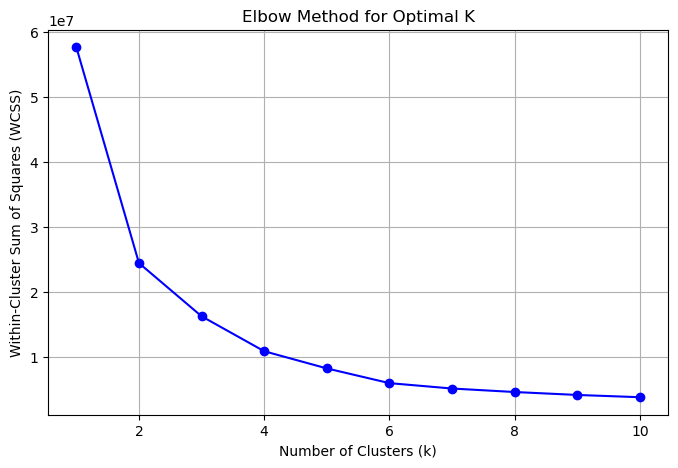

In [11]:
# Calculate the within-cluster sum of squares (WCSS) for different values of k
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=4, init='k-means++')
    kmeans.fit(Xs)
    wcss.append(kmeans.inertia_)
    
#plot the WCSS values against the number of clusters (k)
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.show()

In [12]:
# Create a K-Means clustering model with the optimal number of clusters
optimal_clusters = 2
kmeans = KMeans(n_clusters=optimal_clusters, random_state=4, init='k-means++')

# Fit the model to the data 
kmeans.fit(Xs)

# Assign the cluster labels for each data point
cluster_labels = kmeans.labels_

centroids = kmeans.cluster_centers_

# Add the cluster labels to your DataFrame
df['Cluster'] = cluster_labels

In [13]:
df.tail()

,customer_id,Recency,Frequency,spend,margin,RFM,spend_scaled,margin_scaled,Cluster
518675,6021092,32,1,238.00,-22.00,1,-0.073552,-0.006538,0
518676,6021093,32,2,775.00,60.53,2,-0.044640,-0.002830,0
518677,6021095,32,1,741.38,54.26,2,-0.046450,-0.003112,0
518678,6021098,32,1,2280.00,129.96,2,0.036390,0.000289,0
518679,6021100,32,1,1853.45,135.65,2,0.013425,0.000545,0


In [14]:
df["Cluster"].value_counts()

0    279557
1    239123
Name: Cluster, dtype: int64

We can see that by using 2 clusters, there is relatively equal distribution

Calculate the Cluster Characteristics by comparing the different clusters on the following basis:

    * Number of customers
    * Sales contribution
    * Margin contribution
    * Monthly spend**
    * Shopping frequency

In [17]:
df.head(10)

,customer_id,Recency,Frequency,spend,margin,RFM,spend_scaled,margin_scaled,Cluster
0,1,34,10,6922.59,522.1008,0,0.286349,0.017909,0
1,40,46,3,14497.52,879.5200,0,0.694187,0.033969,0
2,49,52,1,380.00,21.3400,1,-0.065907,-0.004591,1
3,52,36,8,5742.07,1773.8975,0,0.222789,0.074155,0
4,91,34,3,5051.21,1136.3300,0,0.185593,0.045508,0
5,134,34,2,100.00,20.2900,2,-0.080982,-0.004638,0
6,140,32,18,44486.01,14190.1400,0,2.308780,0.632041,0
7,159,44,1,3832.76,249.7800,2,0.119991,0.005673,0
8,169,55,6,1351.73,321.9884,0,-0.013588,0.008918,1
9,175,36,3,766.34,38.6762,0,-0.045106,-0.003812,0


In [18]:
cluster_stats = df.groupby('Cluster').agg({
    'customer_id': 'count', #no of customers
    'spend': 'sum', #sales contribution
    'margin': 'sum', #margin contribution
    'Frequency': 'mean' # shopping frequency
})

In [19]:
cluster_stats.head()

,customer_id,spend,margin,Frequency
Cluster,,,,
0,279557,5.575132e+08,2.448770e+07,3.438801
1,239123,2.745072e+08,3.957925e+07,1.810938


Visualization to compare the cluster characteristics using bar plot

* Comparison of Number of Customers by Cluster

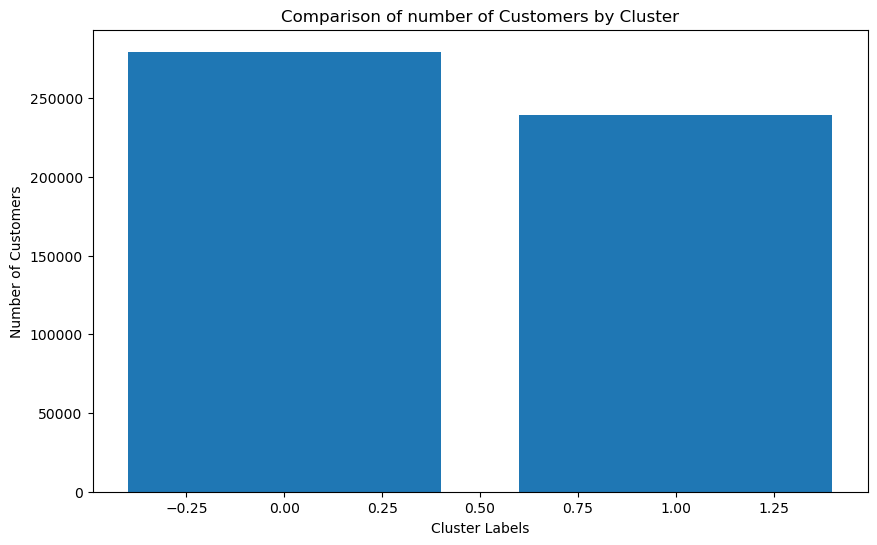

In [20]:
plt.figure(figsize=(10,6))
plt.bar(cluster_stats.index,cluster_stats['customer_id'])
plt.xlabel('Cluster Labels')
plt.ylabel('Number of Customers')
plt.title('Comparison of number of Customers by Cluster')
plt.show()

Comparison of Sales Contribution by Cluster

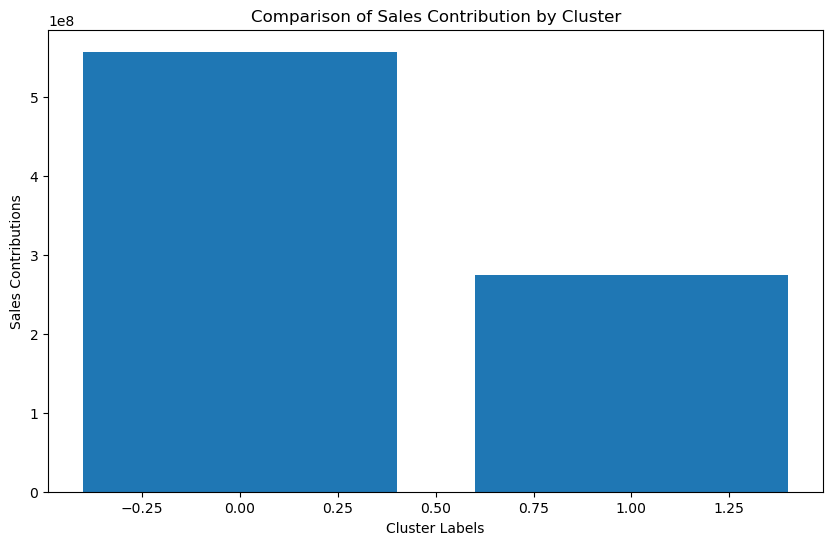

In [21]:
plt.figure(figsize=(10,6))
plt.bar(cluster_stats.index,cluster_stats['spend'])
plt.xlabel('Cluster Labels')
plt.ylabel('Sales Contributions')
plt.title('Comparison of Sales Contribution by Cluster')
plt.show()

Comparison of Margin Contribution by Cluster

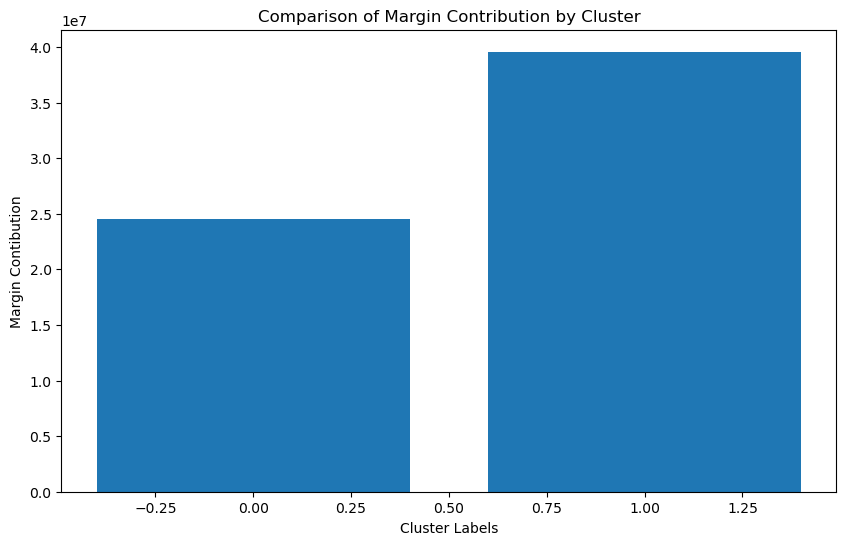

In [22]:
plt.figure(figsize=(10,6))
plt.bar(cluster_stats.index,cluster_stats['margin'])
plt.xlabel('Cluster Labels')
plt.ylabel('Margin Contibution')
plt.title('Comparison of Margin Contribution by Cluster')
plt.show()

Comparison of the Shopping Frequency by Cluster

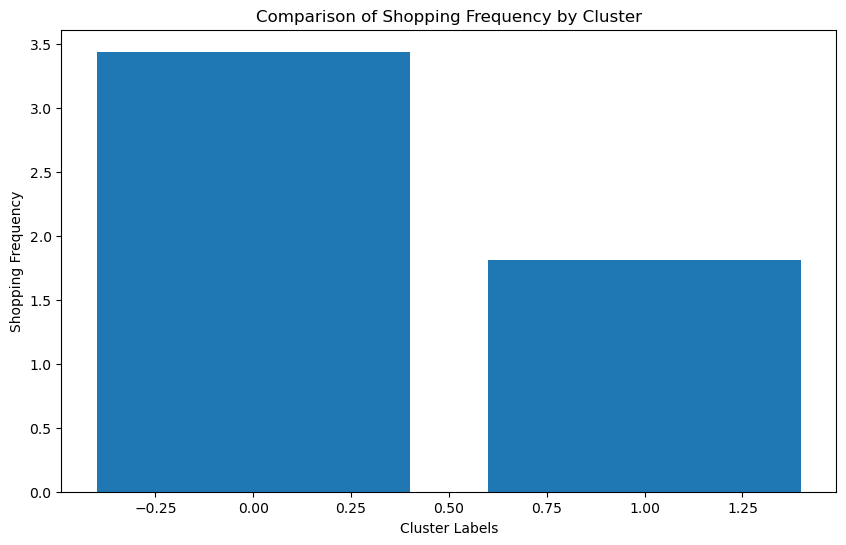

In [23]:
plt.figure(figsize=(10,6))
plt.bar(cluster_stats.index,cluster_stats['Frequency'])
plt.xlabel('Cluster Labels')
plt.ylabel('Shopping Frequency')
plt.title('Comparison of Shopping Frequency by Cluster')
plt.show()

We can see that by using 2 clusters, there is relatively equal distribution:<br>

* **Cluster 0**
> Customers in this cluster have a high spending habit and shop also frequently but the company generate less margin contribution from them. The company can introduce cross selling strategy thus increasing the revenue and profitability to the company. Also identify the product or services with high margin that are popular within this cluster and consider promoting them.
        
* **Cluster 1**
> Customers in this cluster have a low spending habit and low shopping frequency but generate more revenue to the company. The company can encourage them to purchase a high-end version of the product they are currently considering in order to increase the spending contribution. Also the company can engage with them by sending e-mails which provide exclusive offers or promotions which compell them to return to the website.